In [1]:
#!pip install -r purpleair/requirements.txt
#import purpleair



In [2]:
import numpy as np
import pandas as pd
import missingno as msno
import time
import os



import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load the states shape data

def load_states_data():
    !rm states*
    !curl -LJO https://github.com/josh-tollefson/aqi/raw/master/notebooks/states_21basic.zip
    !ls 
    !unzip states_21basic.zip 
    !ls
    
#load_states_data()

In [4]:

usa = gpd.read_file('states.shp')
display(usa.head(2))
display(usa.tail(1))

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."


,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
50,Alaska,51,02,Pacific,AK,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."


In [5]:
def get_sensor_list():
    from purpleair.network import SensorList
    return SensorList()  
    
p = get_sensor_list()

sensors_df = p.to_dataframe(sensor_filter='column',
                    column='6hour_avg',
                    channel='parent')
sensors_df.head()


Initialized 13,774 sensors!


,parent,lat,lon,name,location_type,pm_2.5,temp_f,temp_c,humidity,pressure,...,last_update_check,created,uptime,is_owner,10min_avg,30min_avg,1hour_avg,6hour_avg,1day_avg,1week_avg
id,,,,,,,,,,,,,,,,,,,,,
14633,None,37.275561,-121.964134,Hazelwood canary,outside,8.49,100.0,37.777778,16.0,1010.29,...,None,None,None,False,8.77,9.05,9.02,8.77,9.44,24.12
25999,None,30.053808,-95.494643,Villages of Bridgestone AQI,outside,18.39,94.0,34.444444,38.0,1012.99,...,None,None,None,False,18.82,18.13,17.44,14.00,17.30,17.50
14091,None,37.883620,-122.070087,WC Hillside,outside,8.31,92.0,33.333333,19.0,1005.17,...,None,None,None,False,7.86,8.83,9.04,8.07,9.30,32.09
42073,None,47.185173,-122.176855,#1,outside,3.40,63.0,17.222222,54.0,993.04,...,None,None,None,False,2.97,3.00,2.84,2.16,3.89,21.00
53069,None,47.190197,-122.177992,#2,outside,2.91,72.0,22.222222,47.0,991.89,...,None,None,None,False,2.88,2.87,2.72,2.05,3.85,22.32


3845
Index(['parent', 'lat', 'lon', 'name', 'location_type', 'pm_2.5', 'temp_f',
       'temp_c', 'humidity', 'pressure', 'p_0_3_um', 'p_0_5_um', 'p_1_0_um',
       'p_2_5_um', 'p_5_0_um', 'p_10_0_um', 'pm1_0_cf_1', 'pm2_5_cf_1',
       'pm10_0_cf_1', 'pm1_0_atm', 'pm2_5_atm', 'pm10_0_atm', 'last_seen',
       'model', 'adc', 'rssi', 'hidden', 'flagged', 'downgraded', 'age',
       'brightness', 'hardware', 'version', 'last_update_check', 'created',
       'uptime', 'is_owner', '10min_avg', '30min_avg', '1hour_avg',
       '6hour_avg', '1day_avg', '1week_avg'],
      dtype='object')


id
14633                            Hazelwood canary 
14091                                  WC Hillside
64797        1 5th Avenue Marina Bldg 28 @ El 9 Ft
69629                                1 Iverson Way
67357               10 Alhambra Ct. Portola Valley
                           ...                    
70701                            Zhanger Household
75223                                   Zinn Drive
64013                                      Zinnias
19363                                     Zoe Zone
67815    [Outdoor] Great Hwy bw Moraga and Noriega
Name: name, Length: 3845, dtype: object

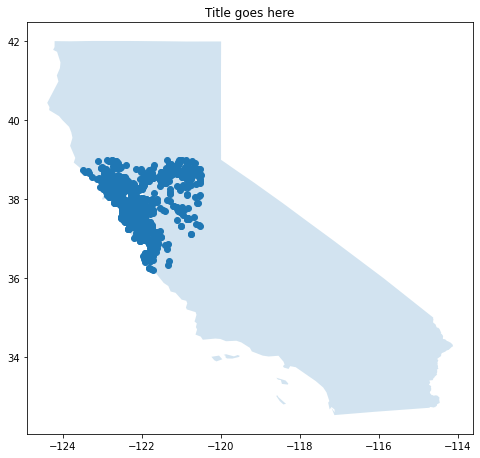

In [43]:

def get_geobox(df, center_lat=37.5, center_lon=-122, width_degrees=1.5):
  return df.loc[  \
                (df['lat'] > center_lat - width_degrees) & \
                (df['lat'] < center_lat + width_degrees) & \
                (df['lon'] < center_lon + width_degrees) & \
                (df['lon'] > center_lon - width_degrees) & \
                (df['location_type'] == 'outside')]



def make_CA_plot(df, title='Title goes here', size=(8, 8)):
    usa = gpd.read_file('states.shp')
    fig, ax = plt.subplots(figsize=size)
    usa[usa.STATE_ABBR == 'CA'].plot(ax=ax, alpha=0.2)
    
    point_data = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.lon, df.lat))
    #display(point_data.head())
    
    point_data.plot(ax=ax, legend=True)
    
    ax.set_title(title)

bay_area_sensors = get_geobox(df=sensors_df)

print(len(bay_area_sensors))
print(bay_area_sensors.columns)
display(bay_area_sensors.name)
make_CA_plot(df=bay_area_sensors)

In [7]:
from purpleair.sensor import Sensor

#se = Sensor(2890)
#df = se.parent.get_historical(weeks_to_get=1,
#                             thingspeak_field='secondary')
#print(df.head())

In [ ]:
def get_existing_sensor_files():
    filenames = os.listdir('data_daily')
    
    sensor_list = []
    
    for filename in filenames:
        first_stuff = filename.split('_')[0]
        sensor_number = first_stuff[6:]
        sensor_list.append(int(sensor_number))
        
    print(len(sensor_list) - len(set(sensor_list)))
    
    return set(sensor_list)
    

def get_non_downloaded_sensor_list(full_list, print_report=False):
    full_sensor_set = set(bay_area_sensors.index)
    downloaded_sensor_set = get_existing_sensor_files()
    
    if print_report:
        print("Length of full set: {}".format(len(full_sensor_set)))
        print("Length of downloaded set: {}".format(len(downloaded_sensor_set)))
        print("Length of remaining: {}".format(len(full_sensor_set - downloaded_sensor_set)))
        print("Sample from full: {}".format(list(full_sensor_set)[0]))
        print("Sample from downloaded: {}".format(list(downloaded_sensor_set)[0]))
    
    return list(full_sensor_set - downloaded_sensor_set)



def bulk_load_daily(sensor_list):
    data_dir = 'daily_data_dump'
    
    if not os.path.exists(data_dir):
        print("data_dir doesn't exist")
        os.mkdir(data_dir, mode=0o666)
        print("made data_dir")
    
    curr_directory = os.path.dirname(os.getcwd())
    
    download_list = get_non_downloaded_sensor_list(
        full_list=sensor_list, print_report=True)
    
    for i, sensor_num in enumerate(download_list):
        start_time = time.time()
        se = Sensor(sensor_num)

        df = se.parent.get_daily(start_year=2018,
                                   start_month=5,
                                   end_year=2020,
                                   end_month=10,
                                    thingspeak_field='secondary')
        
        file_name = "Sensor{}_daily.csv".format(sensor_num)
        
        outfile = os.path.join(
            os.getcwd(),
            'data_daily',
            file_name)
        
        df.to_csv(outfile)
        
        print("File {}/{}, duration={} seconds, {}".format(i, 
                        len(download_list), 
                        time.time() - start_time,
                        file_name
                ))
        time.sleep(5)
        
bulk_load_daily(bay_area_sensors)


0
Length of full set: 3845
Length of downloaded set: 117
Length of remaining: 3728
Sample from full: 65547
Sample from downloaded: 19463
File 0/3728, duration=5.231825828552246 seconds, Sensor57439_daily.csv
File 1/3728, duration=0.8957810401916504 seconds, Sensor73829_daily.csv
File 2/3728, duration=20.801491022109985 seconds, Sensor16489_daily.csv
File 3/3728, duration=2.887223958969116 seconds, Sensor65641_daily.csv
File 4/3728, duration=3.259840965270996 seconds, Sensor65643_daily.csv
File 5/3728, duration=2.540992021560669 seconds, Sensor65655_daily.csv
File 6/3728, duration=18.04567313194275 seconds, Sensor49273_daily.csv
File 7/3728, duration=3.882934093475342 seconds, Sensor65657_daily.csv


In [67]:
os.getcwd()


'/Users/aaron/Desktop/aqi/api_queries/aarons_purpleair_loader'

In [62]:
a = set([1,2,3, 5])
b = set([2,3,4])

list(a)[0]

1

In [44]:
import seaborn as sns

print(df.columns)

sns.lineplot(data=df, x='created_at', y='2.5um/dl')
sns.lineplot(data=df, x='created_at', y='1.0um/dl')

NameError: name 'df' is not defined